# **Hierarchical Clustering for Banking Client Segmentation**

This notebook implements **Hierarchical Clustering** for **banking clients segmentation**, using **Gower Distance** to handle mixed categorical and numerical features.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply Hierarchical Clustering** (Agglomerative approach)
4. **Visualize Clustering with a Dendrogram**
5. **Evaluate Clustering Performance**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [2]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Display first 5 rows
data.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Define categorical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Separate numerical & categorical features
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns]

# Scale numerical features
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(categorical_features)

# Concatenate processed features
X_preprocessed = np.concatenate((X_num_scaled, X_cat_encoded), axis=1)

# Check final shape
print(f'Processed Data Shape: {X_preprocessed.shape}')


Processed Data Shape: (5000, 28)


In [4]:
import gower

# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(X_preprocessed)

# Display first 5 rows
gower_distances[:5, :5]


array([[0.        , 0.3308228 , 0.3688255 , 0.3962298 , 0.46500587],
       [0.3308228 , 0.        , 0.28962833, 0.4133628 , 0.27291024],
       [0.3688255 , 0.28962833, 0.        , 0.17167616, 0.21496232],
       [0.3962298 , 0.4133628 , 0.17167616, 0.        , 0.18863821],
       [0.46500587, 0.27291024, 0.21496232, 0.18863821, 0.        ]],
      dtype=float32)

/var/folders/n7/c2d74g5n7vj2bbwp22w33n2h0000gn/T/ipykernel_77838/637393601.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_distances, method='ward')  # Alternative methods: 'average', 'complete', 'single'


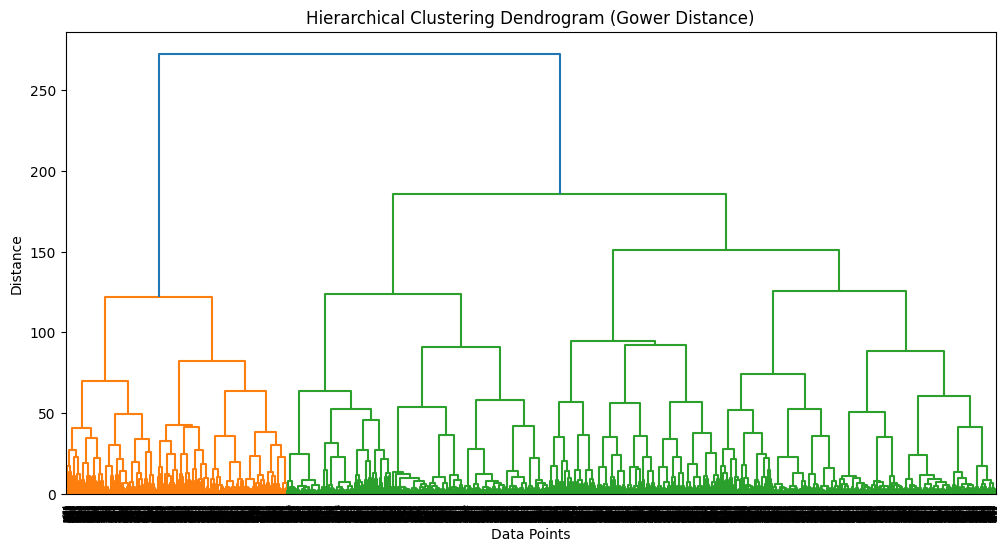

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute linkage matrix
Z = linkage(gower_distances, method='ward')  # Alternative methods: 'average', 'complete', 'single'

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram (Gower Distance)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


In [9]:
from scipy.cluster.hierarchy import fcluster

# Define the number of clusters (modify based on dendrogram)
num_clusters = 7

# Extract cluster labels
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Display cluster assignments
print("Cluster Assignments:")
print(labels[:10])  # Print first 10 labels


Cluster Assignments:
[2 6 4 4 3 3 6 2 2 3]


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Evaluate clustering
ch_score = calinski_harabasz_score(X_preprocessed, labels)
db_score = davies_bouldin_score(X_preprocessed, labels)
sil_score = silhouette_score(gower_distances, labels, metric='precomputed')

print(f"✅ Calinski-Harabasz Score: {ch_score:.4f}")
print(f"✅ Davies-Bouldin Score: {db_score:.4f}")
print(f"✅ Silhouette Score: {sil_score:.4f}")


✅ Calinski-Harabasz Score: 430.6536
✅ Davies-Bouldin Score: 2.3042
✅ Silhouette Score: 0.1495


In [11]:
# Restore feature names for numerical and categorical variables
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
all_feature_names = numerical_features.columns.tolist() + encoded_feature_names.tolist()

# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Reverse MinMax scaling to restore original numerical values
summary_original_scale = summary.copy()
summary_original_scale[numerical_features.columns] = scaler.inverse_transform(summary[numerical_features.columns])

# Convert one-hot encoded categorical values back to original labels
for i, cat_col in enumerate(categorical_columns):
    one_hot_columns = [col for col in summary_original_scale.columns if col.startswith(cat_col + "_")]
    summary_original_scale[cat_col] = summary_original_scale[one_hot_columns].idxmax(axis=1)
    summary_original_scale[cat_col] = summary_original_scale[cat_col].str.split('_').str[1]
    summary_original_scale = summary_original_scale.drop(columns=one_hot_columns)

# Display the DataFrame as a readable table
from IPython.display import display
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)


🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,,,
1,70.955466,2.299595,0.440521,0.434970,0.231393,0.394781,0.578501,0.394951,0.626978,0.344645,0.320798,0.365236,0,5,1,2,2
2,72.077364,2.193410,0.453590,0.463326,0.205062,0.380986,0.600963,0.382375,0.626001,0.327038,0.337727,0.377307,1,5,1,2,2
3,53.039427,2.220430,0.742436,0.747491,0.544079,0.660013,0.638216,0.706936,0.716083,0.627895,0.688651,0.577955,0,2,1,3,3
4,58.229142,2.813161,0.586459,0.596159,0.497661,0.525680,0.551278,0.535084,0.595838,0.466888,0.472234,0.572497,0,2,1,2,3
5,60.532751,2.795852,0.569082,0.569126,0.466190,0.493072,0.553710,0.505799,0.587001,0.437278,0.438637,0.556620,1,2,2,2,3
6,51.850932,2.031056,0.660658,0.661028,0.501586,0.606141,0.664801,0.654555,0.641747,0.594162,0.622775,0.576013,1,2,1,3,3
7,58.284863,2.709178,0.577916,0.579749,0.491910,0.520229,0.560539,0.525764,0.585287,0.456025,0.466929,0.561737,1,2,1,2,3
